In [2]:
import numpy as np 
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score


In [3]:
iris = load_iris()
X = iris.data 
y = iris.target 

### 1. Ensemble model
Check accuray of VotingClassifier

The result of VotingClassifier can be worse than some of its individual models if the base models share the same errors and therefore cannot complement each other 

In [4]:
from sklearn.model_selection import cross_val_score

log_model = LogisticRegression()
svm_model = SVC() # support vector classifier 
tree_model = DecisionTreeClassifier(max_depth = 3)

voting_model = VotingClassifier(estimators=[
    ('log_model', log_model),
    ('svm_model', svm_model),
    ('tree_model', tree_model)
], voting='hard') # voting: hard (majority), soft: average probility of each child 

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)

log_cross_val = cross_val_score(estimator=log_model, X=X, y=y, scoring='accuracy', cv=cv, n_jobs=-1) # n_jobs: chay max cpu dc cap 
svm_cross_val = cross_val_score(estimator=svm_model, X=X, y=y, scoring='accuracy', cv=cv, n_jobs=-1) 
tree_cross_val = cross_val_score(estimator=tree_model, X=X, y=y, scoring='accuracy', cv=cv, n_jobs=-1) 
voting_cross_val = cross_val_score(estimator=voting_model, X=X, y=y, scoring='accuracy', cv=cv, n_jobs=-1)

print(f"LogisticRegression Mean Accuracy: {log_cross_val.mean():.3f}")
print(f"SVC Mean Accuracy: {svm_cross_val.mean():.3f}")
print(f"DecisionTreeClassifier Mean Accuracy: {tree_cross_val.mean():.3f}")
print(f"VotingClassifier Mean Accuracy: {voting_cross_val.mean():.3f}")

LogisticRegression Mean Accuracy: 0.964
SVC Mean Accuracy: 0.963
DecisionTreeClassifier Mean Accuracy: 0.951
VotingClassifier Mean Accuracy: 0.963


### 2. Boostrapping
Test BaggingClassifier với bootstrap=True
boostrapping: lấy mẫu có hoàn lại, nhung mau dc chon nam trong bag

max_samples=100, # Size sample to train is 100 
=> oob = (1 -1/len(X))^100 = (1-1/150)^100 = 0.513 ~ 51%
=> train = 1-51% = 49% of samples of X

BaggingClassifer sometimes could perform worse than its base estimators, especially the base model has low variance, or when boostrap samples reduce the amount of useful information 


In [5]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(  
    DecisionTreeClassifier(),
    n_estimators=200, # chay 200 tree con 
    max_samples=100, # lay moi sample de train la 100 => oob = (1 -1/len(X))^100 = (1-1/150)^100 = 0.513 ~ 51%
    bootstrap=True, # boostrapping: lấy mẫu có hoàn lại, nhung mau dc chon nam trong bag
    n_jobs=-1 # default = None 
)
#bagging_model.fit(X, y)
bagging_cross_val = cross_val_score(estimator=bagging_model, X=X, y=y, scoring='accuracy',cv=cv, n_jobs=-1)
print(f"BaggingClassifier Mean Accuracy: {bagging_cross_val.mean():.3f}")

BaggingClassifier Mean Accuracy: 0.957


### OOB Score
When using bootstrap=True: max_samples = len(X_train)
- Each bootstrap sample often contains ~63% original data
- About 37% of the data is not chosen in each bootstrap sample. (obb = (1-1/N)^N) ~ e^-1 ~ 0.368 ~ 37% với mọi N => train = 63%)
- oob_score = 1: ~37% data will be used as test dataset (out-of-bag)
    - No need to cross validation 
    - No need to split train, test set 
    - The accuracy is the same as 5-fold CV 

In [6]:
idx = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(idx)

index_train = idx[:100] # 100 index for training 
index_test = idx[100:]  # 50 index for testing 

X_train, y_train = X[index_train, : ], y[index_train]
X_test, y_test = X[index_test, : ], y[index_test]

bagging_model = BaggingClassifier(  
    DecisionTreeClassifier(),
    n_estimators=200, 
    max_samples=100, # ratio = 100/len(X_train) -> 
    bootstrap=True,
    oob_score=True, # du lieu out-of-bag ~ 37% of X_train
    n_jobs=-1 
)

bagging_model.fit(X_train, y_train) 
print(f"Out of bag accuracy: {bagging_model.oob_score_}") # oob_score_ stores accuracy

y_pred = bagging_model.predict(X_test)
print(f"Out of bag accuracy with model: {accuracy_score(y_test, y_pred) :.2f}")

Out of bag accuracy: 0.94
Out of bag accuracy with model: 0.94


We get the same result of accuracy on obb and test train. OOB helps detect overfitting because OOB samples act like a built-in validation set that the model has not seen during training.

### 3. Random Forest
Use both ensemble + bootstrapping

In [7]:
from sklearn.ensemble import RandomForestClassifier


rdr_model = RandomForestClassifier(
    n_estimators=100, # number of trees 
    criterion='gini', 
    max_depth=3, 
    max_leaf_nodes=16,
    min_samples_split=10, 
    min_samples_leaf=10,
    bootstrap=True, 
    oob_score=False, 
    max_samples=None # each sample has the size as the train set 
)
rdr_model.fit(X_train, y_train)
y_pred = rdr_model.predict(X_test)
print(f"RandomForest Accuracy: {accuracy_score(y_test, y_pred)}")

RandomForest Accuracy: 0.94


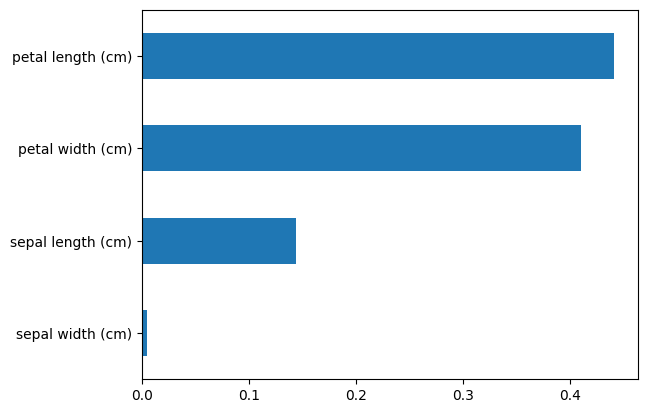

In [15]:
import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.DataFrame({
    'features': iris.feature_names, 
    'importance': rdr_model.feature_importances_
}, index=iris.feature_names)

df['importance'].sort_values(ascending=True).plot.barh()
plt.show()